# Support Vector Machine for Classification

The primary goal of this project is simply to build a support vector classifier from scratch, and to build the necessary functions to tune hyperparameters to produce a reasonably well performing classifier. I've chosen to use Small Business Loan data from https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied in order to test performance.

I want to use my SVM classifier to predict whether or not a company is likely to default on the loan. Because the main goal of the project is not to produce a stellar model, but rather to code an algorithm, I'm going to completely drop all categorical data. I'm also going to use a subset of 1000 samples from the data set: 500 randomly chosen loans that were paid in full, and 500 randomly chosen loans that defaulted.

I will code the necessary functions to perform a grid search cross validation to tune hyperparameters on a training subset, and then use the best combination to measure accuracy on my test subset. 

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import random
from collections import defaultdict
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("SBAnational.csv")

/Users/rebekaharana/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_pos = df.loc[df['MIS_Status'] == 'P I F'].sample(500)
df_neg = df.loc[df['MIS_Status'] != 'P I F'].sample(500)

In [4]:
df = pd.concat([df_pos, df_neg], axis = 0)
df.shape

(1000, 27)

In [5]:
pd.options.display.max_columns = 100

df.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
764699,8023123010,SPOT-NOT CAR WASH,GLENDALE,AZ,85308,LOANS FROM OLD CLOSED LENDERS,DC,811192,27-Jan-95,1995,216,4,2.0,0,0,1,0,N,N,NaN,31-Jul-95,"$635,000.00",$0.00,P I F,$0.00,"$635,000.00","$476,250.00"
854576,9169764007,NORTHWEST ANGLE RESORT & RESTA,ANGLE INLET,MN,56711,MINNESOTA BUS. FINAN CORP,MN,721214,14-Oct-05,2006,240,6,2.0,2,4,1,2,0,N,NaN,15-Feb-06,"$283,000.00",$0.00,P I F,$0.00,"$283,000.00","$283,000.00"
259712,2820855004,Bullock's Bright Beginnings L,LEAGUE CITY,TX,77573,JPMORGAN CHASE BANK NATL ASSOC,IL,624410,20-Nov-07,2008,84,2,2.0,0,0,0,1,Y,S,NaN,30-Nov-07,"$25,000.00",$0.00,P I F,$0.00,"$25,000.00","$21,250.00"
481234,4629525000,Jeff Squibb,Elizabeth,PA,15037,THE HUNTINGTON NATIONAL BANK,OH,323118,8-Apr-11,2011,84,0,2.0,0,0,0,1,Y,N,NaN,1-May-11,"$160,356.00",$0.00,P I F,$0.00,"$50,000.00","$25,000.00"
423392,4093123007,ALFA LAUNDROMAT/CLEANERS/II,SAN ANSELMO,CA,94960,FIRST BANK,MO,812310,15-May-90,1990,108,2,1.0,0,0,1,0,N,N,NaN,31-Oct-90,"$217,573.00",$0.00,P I F,$0.00,"$239,300.00","$203,405.00"


In [6]:
df.columns.tolist()

['LoanNr_ChkDgt',
 'Name',
 'City',
 'State',
 'Zip',
 'Bank',
 'BankState',
 'NAICS',
 'ApprovalDate',
 'ApprovalFY',
 'Term',
 'NoEmp',
 'NewExist',
 'CreateJob',
 'RetainedJob',
 'FranchiseCode',
 'UrbanRural',
 'RevLineCr',
 'LowDoc',
 'ChgOffDate',
 'DisbursementDate',
 'DisbursementGross',
 'BalanceGross',
 'MIS_Status',
 'ChgOffPrinGr',
 'GrAppv',
 'SBA_Appv']

In [7]:
df.dtypes

LoanNr_ChkDgt          int64
Name                  object
City                  object
State                 object
Zip                    int64
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate          object
ApprovalFY            object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
ChgOffDate            object
DisbursementDate      object
DisbursementGross     object
BalanceGross          object
MIS_Status            object
ChgOffPrinGr          object
GrAppv                object
SBA_Appv              object
dtype: object

To begin with, I have a bunch of data that's really numerical data, but which is being held in object format. So I need to work my way through that and convert the df to something more useful.

In [8]:
def remove_currency(df, columns):
    
    """
    Removes the dollar sign and eliminates the commas from the specified columns of a dataframe

    Parameters
    ----------
    df : pandas dataframe
    columns : list 
        columns in df containing currency values

    Returns
    -------
    dataframe
        The original dataframe with currency columns converted to float values

    """

    df1 = df.copy()
    for column in columns:
        for i in df1.index.tolist():
            
            money = df1.loc[i, column]
            
            # remove the dollar sign, if one exists
            money = ''.join(money.split("$"))
            
            # remove any commas if they exist
            money = ''.join(money.split(","))
            
            df1.loc[i, column] = float(money)
            
    return df1

In [9]:
new_df = remove_currency(df, ['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'])

In [10]:
new_df.head(5)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
764699,8023123010,SPOT-NOT CAR WASH,GLENDALE,AZ,85308,LOANS FROM OLD CLOSED LENDERS,DC,811192,27-Jan-95,1995,216,4,2.0,0,0,1,0,N,N,NaN,31-Jul-95,635000,0,P I F,0,635000,476250
854576,9169764007,NORTHWEST ANGLE RESORT & RESTA,ANGLE INLET,MN,56711,MINNESOTA BUS. FINAN CORP,MN,721214,14-Oct-05,2006,240,6,2.0,2,4,1,2,0,N,NaN,15-Feb-06,283000,0,P I F,0,283000,283000
259712,2820855004,Bullock's Bright Beginnings L,LEAGUE CITY,TX,77573,JPMORGAN CHASE BANK NATL ASSOC,IL,624410,20-Nov-07,2008,84,2,2.0,0,0,0,1,Y,S,NaN,30-Nov-07,25000,0,P I F,0,25000,21250
481234,4629525000,Jeff Squibb,Elizabeth,PA,15037,THE HUNTINGTON NATIONAL BANK,OH,323118,8-Apr-11,2011,84,0,2.0,0,0,0,1,Y,N,NaN,1-May-11,160356,0,P I F,0,50000,25000
423392,4093123007,ALFA LAUNDROMAT/CLEANERS/II,SAN ANSELMO,CA,94960,FIRST BANK,MO,812310,15-May-90,1990,108,2,1.0,0,0,1,0,N,N,NaN,31-Oct-90,217573,0,P I F,0,239300,203405


Looking at my data, it appears that ```DisbursementGross```, ```GrAppv```, and ```SBA_Appv``` track essentially the same thing, while ```BalanceGross``` and ```ChgOffPrinGr``` tell you whether or not the loan defaulted. In other words, it makes sense to keep only one of the first three columns, and to dump the latter two entirely.

In [11]:
new_df.drop(['GrAppv', 'SBA_Appv', 'BalanceGross', 'ChgOffPrinGr'], axis = 1, inplace = True)

new_df.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,MIS_Status
764699,8023123010,SPOT-NOT CAR WASH,GLENDALE,AZ,85308,LOANS FROM OLD CLOSED LENDERS,DC,811192,27-Jan-95,1995,216,4,2.0,0,0,1,0,N,N,NaN,31-Jul-95,635000,P I F
854576,9169764007,NORTHWEST ANGLE RESORT & RESTA,ANGLE INLET,MN,56711,MINNESOTA BUS. FINAN CORP,MN,721214,14-Oct-05,2006,240,6,2.0,2,4,1,2,0,N,NaN,15-Feb-06,283000,P I F
259712,2820855004,Bullock's Bright Beginnings L,LEAGUE CITY,TX,77573,JPMORGAN CHASE BANK NATL ASSOC,IL,624410,20-Nov-07,2008,84,2,2.0,0,0,0,1,Y,S,NaN,30-Nov-07,25000,P I F
481234,4629525000,Jeff Squibb,Elizabeth,PA,15037,THE HUNTINGTON NATIONAL BANK,OH,323118,8-Apr-11,2011,84,0,2.0,0,0,0,1,Y,N,NaN,1-May-11,160356,P I F
423392,4093123007,ALFA LAUNDROMAT/CLEANERS/II,SAN ANSELMO,CA,94960,FIRST BANK,MO,812310,15-May-90,1990,108,2,1.0,0,0,1,0,N,N,NaN,31-Oct-90,217573,P I F


In [12]:
# dropping all categorical variables

to_drop=['LoanNr_ChkDgt','Name','City','State','Zip','Bank','BankState','NAICS','ApprovalDate','ApprovalFY',
         'RevLineCr','LowDoc','ChgOffDate','DisbursementDate', 'FranchiseCode']

new_df.drop(to_drop, axis = 1, inplace = True)

And finally, I want to convert ```MIS_Status``` to 1 (for ```P I F ```) or -1 (otherwise). 

In [13]:
new_df.replace("P I F", 1, inplace = True)
new_df.replace("CHGOFF", -1, inplace = True)

In [14]:
new_df.head(10)

,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,DisbursementGross,MIS_Status
764699,216,4,2.0,0,0,0,635000,1.0
854576,240,6,2.0,2,4,2,283000,1.0
259712,84,2,2.0,0,0,1,25000,1.0
481234,84,0,2.0,0,0,1,160356,1.0
423392,108,2,1.0,0,0,0,217573,1.0
334596,60,6,1.0,0,6,2,40000,1.0
301261,12,1,1.0,2,1,2,50000,1.0
194575,12,3,1.0,0,3,1,25000,1.0
850546,240,5,1.0,2,0,1,289000,1.0
101001,180,10,1.0,0,0,0,179500,1.0


The cost function for the support vector machine is given by:

$$ 
\left[\frac{1}{n}\sum_{i = 1}^{n} C \times \max(0, 1-y_i(w x_i-b))\right] +  || w ||^2
$$


In [15]:
# breaking the data frame into features and response

features = new_df.drop(['MIS_Status'], axis = 1).copy()
response = new_df['MIS_Status'].copy()

In [16]:
def normalize_params(X, cols):
    
    """
    Normalizes a subset of the columns in X

    Parameters
    ----------
    X : numpy array or dataframe
    cols : list
        columns in X to normalize

    Returns
    -------
    numpy array or dataframe
        The dataframe X with specified columns normalized
    list
        The means and standard deviations used in the normalization

    """
    # create a list of columns to keep as is
    
    to_keep = [col for col in X.columns.tolist() if col not in cols]
    
    # compute the means and standard deviations of the columns to normalize
    means = np.mean(X[cols], axis = 0)
    stdev = np.std(X[cols], axis = 0)
    
    # create a new dataframe with only the normalized columns of the original
    normed = (X[cols] - means)/stdev
    
    # add the unaltered columns back into the dataframe
    for col in to_keep:
        normed[col] = X[col]
        
    # reset the index
    normed.reset_index(drop = True, inplace = True)
    
    return normed, [means, stdev]

In [17]:
# normalizing the desired features

features, params = normalize_params(features, ['Term','CreateJob','RetainedJob','DisbursementGross', 'NoEmp'])

# changing inputs and outputs into numpy arrays

features = np.array(features)
response = np.array(response)

In [18]:
def pred_y(X, w):
    
    """
    Computes the predicted values of y for an input array X and weights w

    Parameters
    ----------
    X : numpy array
        The input features for some observations
    w : list or numpy array
        The weight vector

    Returns
    -------
    numpy array (real valued)
        The predicted values of y

    """

    preds = np.dot(X, w)
    
    return preds

In [19]:
def train_test_split(X, y, frac):
    
    """
    Randomly splits a dataframe into training and testing data

    Parameters
    ----------
    X : numpy array
        feature data
    y : numpy array
        response data
    frac : float between 0 and 1
        the fraction of the observations to put in the training set

    Returns
    -------
    numpy arrays
        training feature data
        testing feature data
        training response data
        testing response data

    """
    
    # produce a list of indices for X and y and shuffle them randomly
    indices = list(range(X.shape[0]))
    random.shuffle(indices)
    
    # compute the number of indices for the test data
    split = int(len(indices)*frac)
    
    # split the indices into training and test indices
    train = indices[ :split]
    test = indices[split: ]
    
    # split X and y into training and test data
    
    X_train = X[train]
    X_test = X[test]
    
    y_train = y[train]
    y_test = y[test]
    
    return X_train, X_test, y_train, y_test

In [20]:
def cross_valid_splits(X, k):

    """
    Randomly divides the rows of X into k equal groups

    Parameters
    ----------
    X : numpy array
    k : integer
        the number of (roughly equal) pieces into which to divide the data

    Returns
    -------
    list of lists
        A list of lists of indices assigned to each split
        
    """
    
    # find the indices of X and shuffles them
    indices = list(range(X.shape[0]))
    random.shuffle(indices)
    
    splits = []
    
    # compute the size of the splits
    if len(indices)%k == 0:
        length = int(len(indices)/k)
    else:
        length = len(indices)//k + 1
    
    # divides the shuffled list of indices into sublists of the correct length
    
    for i in range(k):
        
        split = indices[length*i: length*(i+1)]
        splits.append(split)
    
    
    return splits

In [21]:
def norm_2_squared(z):
    
    """
    Computes the Euclidean distance between two points in  R^n

    Parameters
    ----------
    p1 : list or numpy array
        A point in R^n
    p2 : list or numpy array
        A second point in R^n

    Returns
    -------
    float
        The Euclidean distance between the two points

    """

    
    norm_2 = sum([i**2 for i in z])
    
    try:
        return norm_2[0]
    except:
        return norm_2

In [22]:
def SVM_cost(x, y, w, C):
    
    """
    Computes SVM cost

    Parameters
    ----------
    x : numpy array
        features
    y : numpy array
        measured responses
    w : numpy array
        feature weights
    C : float or integer
        penalty

    Returns
    -------
    float
        The SVM cost for the current values of w and C

    """
    # compute the predicted outcomes for the given x and w
    pred = np.dot(x, w)
    
    # computes distances
    dist = 1 - (y*pred).reshape(-1, 1)
    
    # adds a column of zeros to the distance array
    zeros = np.zeros(dist.shape)
    dist = np.concatenate([dist, zeros], axis = 1)
    
    # finds the max values of each row
    maxes = np.max(dist, axis = 1)
    
    # produces the vector of costs for each point
    cost_vector = C*maxes + 0.5*norm_2_squared(w)
    
    # averages them to obtain total cost
    total_cost = np.sum(cost_vector) / len(cost_vector)
    
    return total_cost

In [23]:
def SVM_grad(X, y, w, C):
    
    """
    Computes the SVM gradient for the given values

    Parameters
    ----------
    x : numpy array
        features
    y : numpy array
        measured responses
    w : numpy array
        feature weights
    C : float or integer
        penalty

    Returns
    -------
    list
        The gradiant of the cost function for the given weight vector

    """
    # computes the distance between observed and predicted values of y
    distance = 1 - y * np.dot(X, w)
    
    # initialize the gradient as zeros
    dw = np.zeros(len(w))
    
    # if the prediction is right (or nearly right), we add w to our gradient
    # if the prediction is wrong, we add a penalty term to our gradient
    for ind, d in enumerate(distance):
        if max(0, d) == 0:
            di = w
        else:
            di = w - C * y[ind] * X[ind]
        dw += di
    
    # compute the mean of the gradients
    dw = dw / len(y)
    
    return dw

In [24]:
def batches(df, size):
    
    """
    Randomly groups the rows of the dataframe into batches of size size

    Parameters
    ----------
    df : numpy array
        features
    size : integer
        the desired batch sizes

    Returns
    -------
    list of lists
        The Euclidean distance between the two points

    """

    # create a list of indices of the array and shuffle them
    indices = list(range(df.shape[0]))
    random.shuffle(indices)
    
    # if size is "all", then mini_batches is a list containing the list of indices
    if size == "all":
        mini_batches = [indices]

    # if the number of observations is evenly divisible by the number of minibatches, the 
    # the number of mini batches is just observations/num minibatches. Otherwise it's one 
    # more than the floor of this number
    
    else:
        if len(indices)%size == 0:
            num_batches = len(indices) // size
            
        else:
            num_batches = 1 + len(indices) // size
    
        mini_batches = [indices[size * a : size * (a + 1)] for a in range(num_batches)]
    
    return mini_batches

In [25]:
def cross_entropy(y, y_pred):
    
    """
    Computes the cross entropy loss between observed and predicted responses

    Parameters
    ----------
    y : numpy array
        the observed response values
    y_pred : numpy array
        the predicted response values

    Returns
    -------
    float
        the cross entropy cost

    """

    loss = 0
    
    for i in range(len(y)):
        if y[i] == 1:
            loss += -np.log(np.max([1e-10, y_pred[i]]))
        else:
            loss += -np.log(np.max([1e-10, 1 - y_pred[i]]))
    return loss

In [26]:
def prediction_split(y_pred):
    
    """
    Given a prediction vector y_pred, assigns values of 1 or -1 

    Parameters
    ----------
    y_pred : numpy array
        predicted response values

    Returns
    -------
    list
        list of categorical assignments for y_pred

    """
    
    # assigns a value of 1 if the value of y_pred is positive (or zero) and a value of -1 otherwise
    
    predictions = [-1 if i < 0 else 1 for i in y_pred]
    
    return predictions

In [27]:
def accuracy(y, y_pred):
    
    """
    Computes the accuracy of categorical predictions

    Parameters
    ----------
    y : list or numpy array 
        values must be in {-1, 1}
    y_pred : list or numpy array
        values must be in {-1, 1}

    Returns
    -------
    float
        The percentage of correct predictions

    """

    correct = 0
    incorrect = 0
    
    # counts the number of correct and incorrect predictions
    
    for i in range(len(y)):
        if y[i] == y_pred[i]:
            correct += 1
        else:
            incorrect += 1
    
    # returns the fraction of correctly predicted values

    return correct/(correct + incorrect)

In [28]:
def add_bias(X):
    
    """
    Adds a bias term to X

    Parameters
    ----------
    X : numpy array
        features

    Returns
    -------
    numpy array
        The original array with a column of ones added

    """

    X = np.concatenate([X, np.ones(X.shape[0]).reshape(-1, 1)], axis = 1)
    
    return X

In [29]:
# Splitting my data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(features, response, .8)

print(len(X_train))
print(len(y_test))

800
200


In [30]:
def SVM_classifier(x, y, C, alpha, batch_size, epochs, verbose = False):
    
    """
    Fits an SVM classifer model for the given data according to the specified parameters

    Parameters
    ----------
    x : numpy array
        feature data
    y : numpy array
        observed response data
    C : float
        the cost parameter
    alpha : float
        the learning rate
    batch_size : int or "all"
        number of observations to consider for each cycle
    epochs : int
        the number of full passes through the data
    verbose : boolean
        if set to True, prints out cost at each 4^n th cycle, default is False

    Returns
    -------
    numpy array
        w : The computed weight vector
    
    list
        mini_costs : the batch size costs after each cycle
        cross_costs : the full data cross entropy costs after each epoch
        accuracies : the full data accuracy after each epoch

    """

    # Add a bias term to x
    
    X = add_bias(x)
    
    # randomize a starting weight vector w
    
    w = [random.random() for i in range(X.shape[1])]

    mini_costs = []
    cross_costs = []
    accuracies = []
    
    count = 0
    
    # find indices for mini batches of size batch_size
    
    mini_batches = batches(X, batch_size)
    
    for epoch in range(epochs):
        
        # compute cross entropy costs and accuracies on the entire dataset and store them in lists
        preds = pred_y(X, w)
        predictions = prediction_split(preds)
        cross_costs.append(cross_entropy(y, preds))
        accuracies.append(accuracy(y, predictions))
        
        for batch in mini_batches:
            
            # increase count by 1
            count += 1 
    
            # compute the gradient on the current mini_batch
            grad = SVM_grad(X[batch], y[batch], w, C)
            
            # update the weights
            w = w - alpha * grad
            
            # compute the cost on the minibatch with the updated weights and append it to a list
            cost = SVM_cost(X[batch], y[batch], w, C)
            mini_costs.append(cost)
            
            if verbose == True:
                if (np.log(count)/np.log(4)) == int(np.log(count)/np.log(4)):
                    print(count,w, cost)
        
    
    return w, mini_costs, cross_costs, accuracies

In [31]:
w, mini_costs, cross_costs, accuracies = SVM_classifier(features, response, C = 1000, alpha = .000001, batch_size = 50, epochs = 1000)

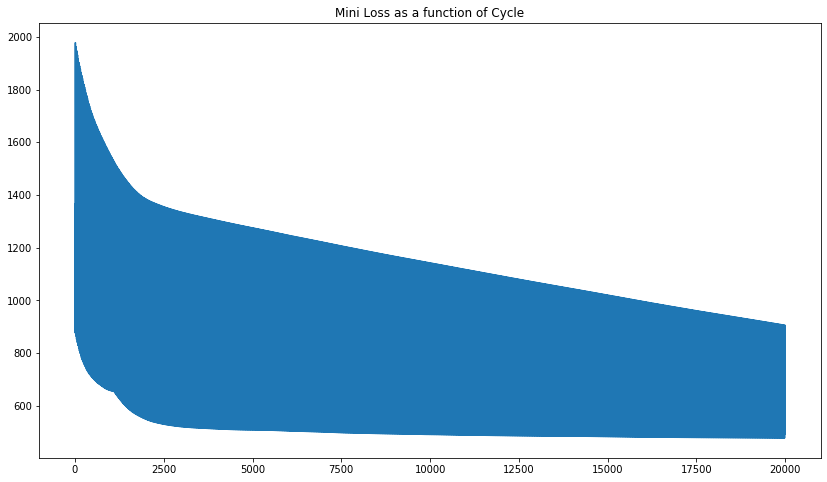

In [32]:
# lineplot of batch costs as a function of number of cycles

plt.figure(figsize = (14, 8))

plt.title("Mini Loss as a function of Cycle")

sns.lineplot(x = list(range(len(mini_costs))), y = mini_costs)

xlabel = "Cycles"
ylabel = "Loss"

plt.show()
plt.close()

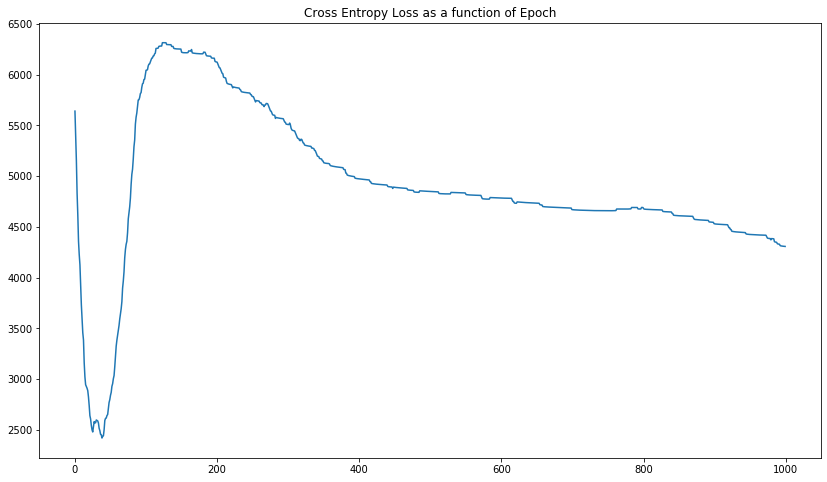

In [33]:
# lineplot of cross entropy costs as a function of epochs

plt.figure(figsize = (14, 8))

plt.title("Cross Entropy Loss as a function of Epoch")

sns.lineplot(x = list(range(len(cross_costs))), y = cross_costs)

xlabel = "Epochs"
ylabel = "Loss"

plt.show()
plt.close()

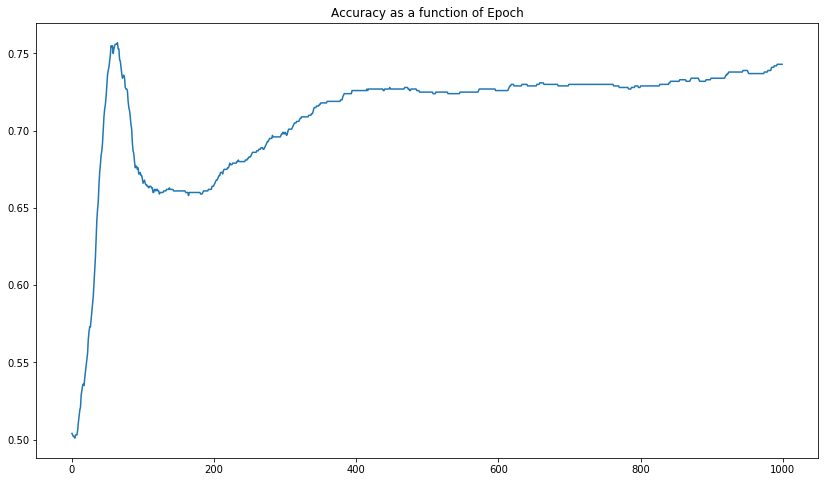

In [34]:
# lineplot of accuracy as a function of epochs

plt.figure(figsize = (14, 8))

plt.title("Accuracy as a function of Epoch")

sns.lineplot(x = list(range(len(accuracies))), y = accuracies)

xlabel = "Epochs"
ylabel = "Accuracy"

plt.show()
plt.close()

OK, so now this seems to be working reasonably well. I'm not getting perfect separation, which is in line with what I would expect from a dataset like this. Now, I want to go ahead and set up some sort of cross validation thing here so that I can tune the parameters.

In [36]:
def cross_validation_SVC(x, y, C, alpha, batch_size, epochs, folds = 3, verbose = True):
    
    """
    Performs k-fold cross validation with a support vector classifier

    Parameters
    ----------
    x : numpy array
        the feature data
    y : numpy array
        the response data
    C : list of floats
        the cost parameters to consider
    alpha : list of floats
        the learning rates to consider
    batch_size : list of ints
        the batch sizes to consider
    epochs : list for ints
        the number of training epochs to consider
    folds : int
        the number of folds to use for cross validation, default is 3
    verbose : boolean
        if true, prints accuracy for each combination of parameters, default is True
        
    Returns
    -------
    list
        The best performing combination for C, alpha, batch_size, and epochs
    float
        The accuracy of the best performing combination
    """

    
    combinations = []
    
    # set best_accuracy to 0 and best_combo to None
    best_accuracy = 0
    best_combo = None
    
    # create a list of all combinations produced by the input lists for C, alpha, batch_size, and epochs 
    for c in C:
        for a in alpha:
            for b in batch_size:
                for e in epochs:
                    combinations.append([c, a, b, e])
                    
    for combo in combinations:
        
        # split the data into folds
        
        indices = list(range(len(x)))
        test_splits = cross_valid_splits(x, folds)
        
        # reset split_accuracies to an empty list
        split_accuracies = []
        
        for split in test_splits:
            
            # fitting the model to the data not found in the given split
            to_fit = list(set(indices) - set(split))
            
            w, m, c, a = SVM_classifier(x[to_fit], y[to_fit], combo[0], combo[1], 
                                        combo[2], combo[3], verbose = False)
            
            # making predictions and finding accuracy on the split data
            preds = pred_y(add_bias(x[split]), w)
            preds = prediction_split(preds)
            a = accuracy(preds, y[split])
            
            # appending the computed accuracy
            split_accuracies.append(a)
        
        # finding the mean of the accuracies for a given combination
        acc = np.mean(split_accuracies)
        if verbose == True:
            print('combo is: ', combo, 'accuracy is:', acc)  
        
        # updating best_accuracy and best_combo if appropriate
        if acc > best_accuracy:
            best_accuracy = acc
            best_combo = combo
                
    return best_combo, best_accuracy

In [37]:
batch_sizes = [1, 50, "all"]
C = [100, 1000]
alpha = [0.0001, 0.00001, 0.000001]
epochs = [50, 250, 1000]


best_combo, best_accuracy = cross_validation_SVC(X_train, y_train, C, alpha, batch_sizes,
                                                 epochs, folds = 3, verbose = True)

combo is:  [100, 0.0001, 1, 50] accuracy is: 0.7512038523274479
combo is:  [100, 0.0001, 1, 250] accuracy is: 0.7675180460514582
combo is:  [100, 0.0001, 1, 1000] accuracy is: 0.7862399444303643
combo is:  [100, 0.0001, 50, 50] accuracy is: 0.6812912430889959
combo is:  [100, 0.0001, 50, 250] accuracy is: 0.726235063313715
combo is:  [100, 0.0001, 50, 1000] accuracy is: 0.7737884035932527
combo is:  [100, 0.0001, 'all', 50] accuracy is: 0.6237081467714229
combo is:  [100, 0.0001, 'all', 250] accuracy is: 0.6849755474829395
combo is:  [100, 0.0001, 'all', 1000] accuracy is: 0.7162428543268282
combo is:  [100, 1e-05, 1, 50] accuracy is: 0.748786760909765
combo is:  [100, 1e-05, 1, 250] accuracy is: 0.787488383881051
combo is:  [100, 1e-05, 1, 1000] accuracy is: 0.7887884505270667
combo is:  [100, 1e-05, 50, 50] accuracy is: 0.5449579003688998
combo is:  [100, 1e-05, 50, 250] accuracy is: 0.6587301587301587
combo is:  [100, 1e-05, 50, 1000] accuracy is: 0.716247547708222
combo is:  [100, 

And finally, determining how this performs on our testing data

In [38]:
# Fitting the model with the best performing parameters to the whole of the training set

w, mini_costs, cross_costs, accuracies = SVM_classifier(X_train, y_train, best_combo[0], 
                                                        best_combo[1], best_combo[2], best_combo[3], 
                                                        verbose = False)

# Adding a bias to the testing set

X_test = add_bias(X_test)

# Making predictions using the computed w

predictions = pred_y(X_test, w)

# Scaling them...

predictions = prediction_split(predictions)

# And computing their accuracy

performance = accuracy(predictions, y_test)

print("The accuracy on the test set of the model with tuned hyper parameters is: ", np.around(performance*100, 2), "%")
print("The best choice of hyper parameters is :")
print("                                    C : ", best_combo[0])
print("                                alpha : ", best_combo[1])
print("                          batch sizes : ", best_combo[2])
print("                               epochs : ", best_combo[3])

The accuracy on the test set of the model with tuned hyper parameters is:  76.0 %
The best choice of hyper parameters is :
                                    C :  1000
                                alpha :  1e-05
                          batch sizes :  50
                               epochs :  1000


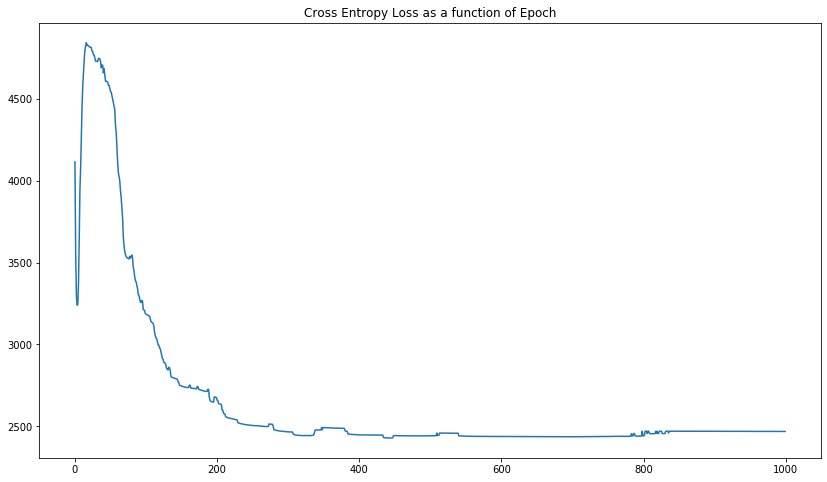

In [41]:
plt.figure(figsize = (14, 8))

plt.title("Cross Entropy Loss as a function of Epoch")

sns.lineplot(x = list(range(len(cross_costs))), y = cross_costs)

xlabel = "Epochs"
ylabel = "Loss"

plt.show()
plt.close()

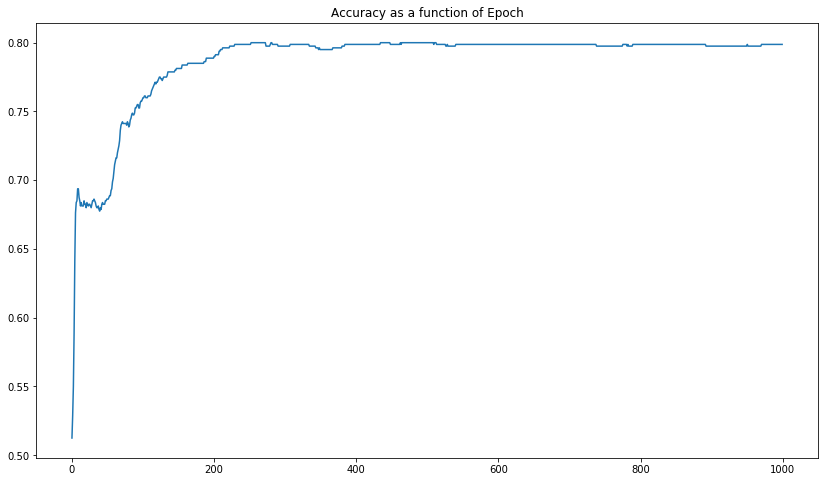

In [42]:
plt.figure(figsize = (14, 8))

plt.title("Accuracy as a function of Epoch")

sns.lineplot(x = list(range(len(accuracies))), y = accuracies)

xlabel = "Epochs"
ylabel = "Accuracy"

plt.show()
plt.close()

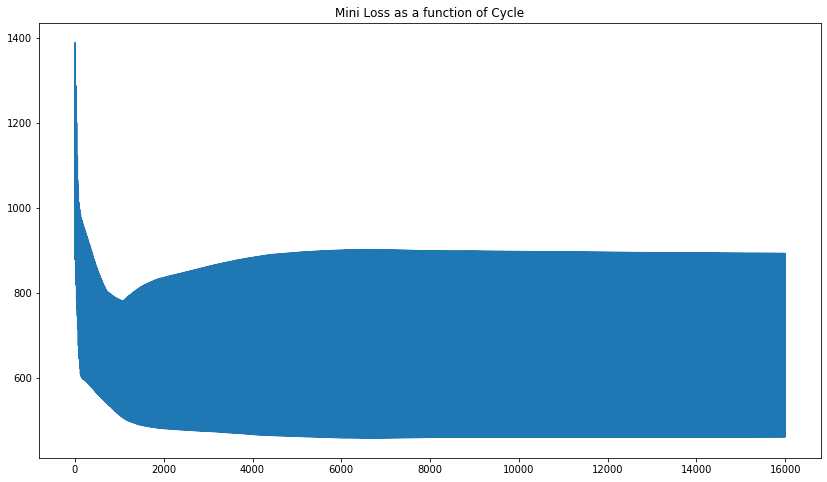

In [43]:
plt.figure(figsize = (14, 8))

plt.title("Mini Loss as a function of Cycle")

sns.lineplot(x = list(range(len(mini_costs))), y = mini_costs)

xlabel = "Cycles"
ylabel = "Loss"

plt.show()
plt.close()

# Conclusion

The model created here can accurately predict the outcome on unseen data roughly 76% of the time. This is considerably better than either random chance or assigning each observation to the same outcome. While this is not sufficiently high to be useful in a practical sense (that would certainly require feature engineering, and probably something with considerably more flexibility than a linear SVM), it is high enough to make me think that my algorithm is performing as desired.